In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import os
from astropy.modeling import models
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from scipy.special import voigt_profile

## Moving to the folder with the files

In [2]:
location = '/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/Solar-data/2023-01-21'
os.chdir(location)

# Studying solar spectrum of one day at one time

## Opening file

In [3]:
test = pf.open('Corr-data/r.NIRPS.2023-01-21T12:03:01.888_S2D_BLAZE_A_CORR.fits')
test.info()

Filename: Corr-data/r.NIRPS.2023-01-21T12:03:01.888_S2D_BLAZE_A_CORR.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1045   ()      
  1  SCIDATA       1 ImageHDU        10   (4084, 71)   float32   
  2  ERRDATA       1 ImageHDU        10   (4084, 71)   float32   
  3  QUALDATA      1 ImageHDU        12   (4084, 71)   int16 (rescales to uint16)   
  4  WAVEDATA_VAC_BARY    1 ImageHDU        10   (4084, 71)   float64   
  5  WAVEDATA_AIR_BARY    1 ImageHDU        10   (4084, 71)   float64   
  6  DLLDATA_VAC_BARY    1 ImageHDU        10   (4084, 71)   float64   
  7  DLLDATA_AIR_BARY    1 ImageHDU        10   (4084, 71)   float64   
  8  SCIDATA_CORR    1 ImageHDU         8   (4084, 71)   float64   
  9  SCIDATA_CORR    1 ImageHDU         8   (4084, 71)   float64   
 10  ERRDATA_CORR    1 ImageHDU         8   (4084, 71)   float64   
 11  TELLURIC      1 ImageHDU         8   (4084, 71)   float64   


In [4]:
test[0].header['HIERARCH ESO TEL AIRM START']

2.44367343085998

## Plotting the spectrum and other interesting quantities

In [5]:
#Get the wavelength of each pixel in a vacuum
lamda = test[4].data
#Get the output flux for each order, telluric corrected in a vacuum and the corresponding errorbars
spctr = test[8].data
err = test[10].data
#Get the DLL 
DLL = test[6].data

print(lamda.shape, spctr.shape, DLL.shape)

(71, 4084) (71, 4084) (71, 4084)


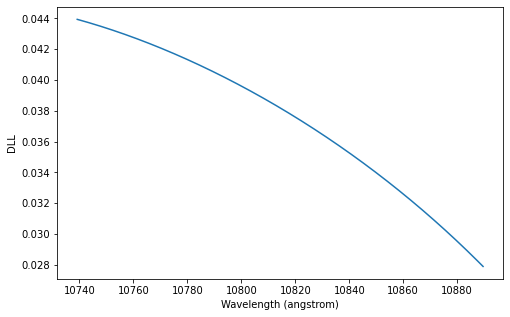

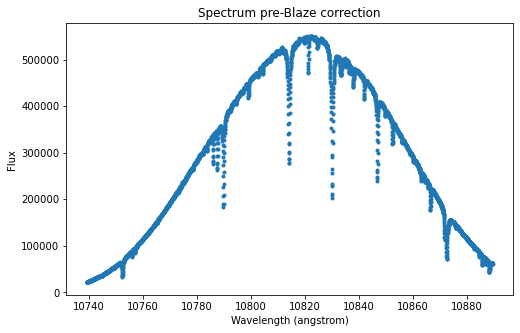

In [6]:
plt.figure(figsize=[8, 5])
plt.plot(lamda[14], DLL[14])
plt.xlabel('Wavelength (angstrom)')
plt.ylabel('DLL')
plt.show()

plt.figure(figsize=[8, 5])
plt.errorbar(lamda[14], spctr[14], yerr = err[14], fmt='.')
plt.xlabel('Wavelength (angstrom)')
plt.ylabel('Flux')
plt.title('Spectrum pre-Blaze correction')
plt.show()

## Retrieving the Blaze data used for calibration that night

In [7]:
blaze_HA = pf.open('Blaze-data/r.NIRPS.2023-01-21T09:44:20.700_BLAZE_A.fits')
blaze_HE = pf.open('Blaze-data/r.NIRPS.2023-01-21T09:25:46.002_BLAZE_A.fits')
blaze_HE[0].header['HIERARCH ESO INS MODE']

'HE'

## Plotting the Blaze data

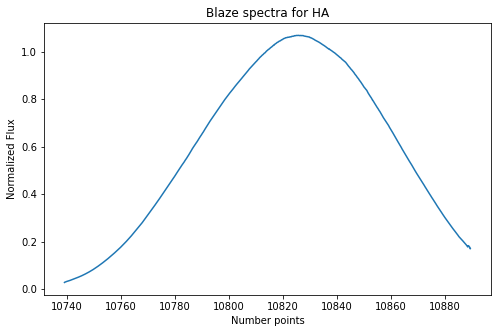

In [8]:
blaze_spctr_HA = blaze_HA[1].data
blaze_spctr_HE = blaze_HE[1].data

plt.figure(figsize=[8, 5])
plt.plot(lamda[14], blaze_spctr_HA[14])
plt.title('Blaze spectra for HA')
plt.xlabel('Number points')
plt.ylabel('Normalized Flux')
plt.show()

## Correcting the bell shape of the spectrum with the Blaze data

In [9]:
new_spctr = spctr[14]/blaze_spctr_HA[14]

Text(0.5, 1.0, 'Spectrum Blaze corrected')

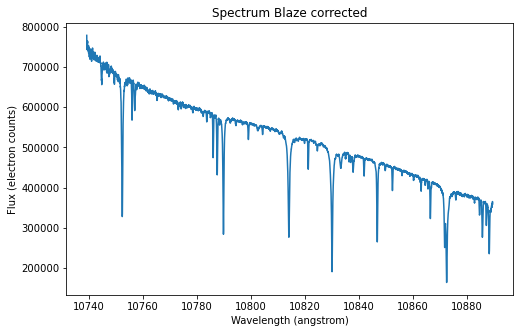

In [10]:
plt.figure(figsize=[8, 5])
plt.plot(lamda[14], new_spctr)
plt.xlabel('Wavelength (angstrom)')
plt.ylabel('Flux (electron counts)')
plt.title('Spectrum Blaze corrected')

## Correcting the decreasing continuum of the spectrum

### Using 1. The DLL

In [11]:
corr_spctr = new_spctr/DLL[14]

Text(0.5, 1.0, 'Spectrum DLL corrected')

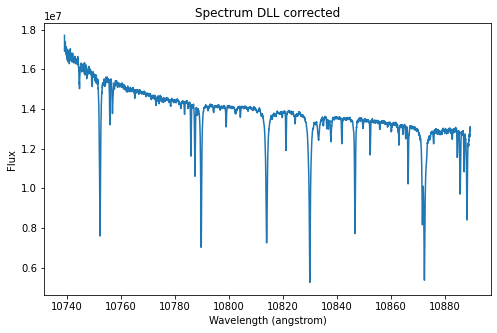

In [12]:
plt.figure(figsize=[8, 5])
plt.plot(lamda[14], corr_spctr)
plt.xlabel('Wavelength (angstrom)')
plt.ylabel('Flux')
plt.title('Spectrum DLL corrected')

### Using 2. The Black Body spectrum of the Sun

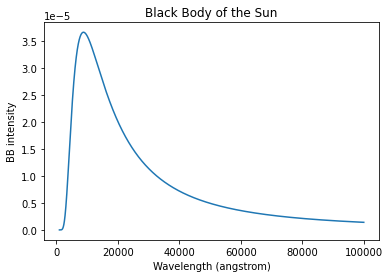

In [13]:
Sun_BB = models.BlackBody(temperature = 5778*u.K)
wav = np.linspace(1000, 100000, 10000)*u.AA
plt.plot(wav, Sun_BB(wav))
plt.xlabel('Wavelength (angstrom)')
plt.ylabel('BB intensity')
plt.title('Black Body of the Sun')

corr_wav = np.linspace(min(lamda[14]), max(lamda[14]), len(lamda[14]))
corr_BB = Sun_BB(corr_wav*u.AA).value

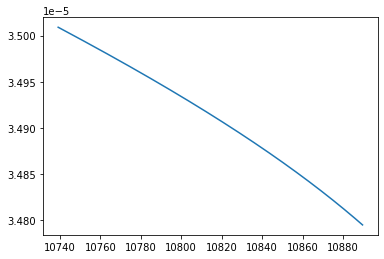

In [14]:
plt.plot(lamda[14], corr_BB)

In [15]:
sec_corr_spctr = corr_spctr/corr_BB

Text(0.5, 1.0, 'Spectrum DLL and BB corrected')

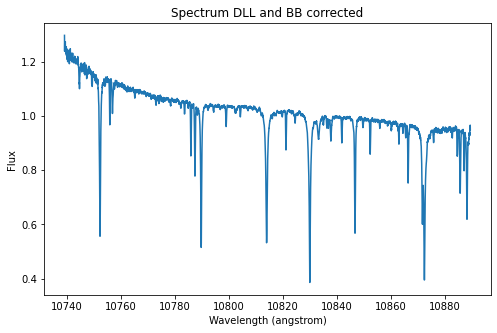

In [16]:
plt.figure(figsize=[8, 5])
plt.plot(lamda[14], sec_corr_spctr/np.mean(sec_corr_spctr))
plt.xlabel('Wavelength (angstrom)')
plt.ylabel('Flux')
plt.title('Spectrum DLL and BB corrected')